In [1]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

font = 'Arial'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = font
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = font
plt.rcParams['mathtext.it'] = font
plt.rcParams['mathtext.bf'] = font
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5

linewidth = 2.5

# Utils

In [2]:
def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

In [3]:
def _decorate_axis(ax, wrect=10, hrect=10, ticklabelsize='large'):
    """Helper function for decorating plots."""
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    # Deal with ticks and the blank space at the origin
    ax.tick_params(length=0.1, width=0.1, labelsize=ticklabelsize)
    ax.spines['left'].set_position(('outward', hrect))
    ax.spines['bottom'].set_position(('outward', wrect))
    return ax

In [4]:
def plot_interval_estimates(point_estimates,
                            interval_estimates,
                            metric_idx,
                            algorithms=None,
                            colors=None,
                            color_palette='colorblind',
                            max_ticks=4,
                            subfigure_width=3.4,
                            row_height=0.37,
                            xlabel_y_coordinate=-0.1,
                            xlabel='Normalized Score',
                            **kwargs):


    num_teachers = 6
    figsize = (subfigure_width * num_teachers, row_height * len(algorithms))
    fig, axes = plt.subplots(nrows=1, ncols=num_teachers, figsize=figsize)
    if colors is None:
        colors = dict(zip(algorithms, sns.color_palette(color_palette)))
    h = kwargs.pop('interval_height', 0.6)
    
    teacher_name_list = ['Oracle', 'Mistake', 'Equal', 'Skip', 'Myopic', 'Stoc']
    
    for idx, teacher_name in enumerate(teacher_name_list):
        for alg_idx, algorithm in enumerate(algorithms):
            ax = axes[idx]
            algo_name = algorithm + ' (' + teacher_name + ')'
            # Plot interval estimates.
            lower, upper = interval_estimates[algo_name][:, metric_idx]
            ax.barh(
                y=alg_idx,
                width=upper - lower,
                height=h,
                left=lower,
                color=colors[algorithm],
                alpha=0.75,
                label=algorithm)
            # Plot point estimates.
            ax.vlines(
                x=point_estimates[algo_name][metric_idx],
                ymin=alg_idx - (7.5 * h / 16),
                ymax=alg_idx + (6 * h / 16),
                label=algorithm,
                color='k',
                alpha=0.5)

        ax.set_yticks(list(range(len(algorithms))))
        ax.xaxis.set_major_locator(plt.MaxNLocator(max_ticks))
        if idx != 0:
            ax.set_yticks([])
        else:
            ax.set_yticklabels(algorithms, fontsize='x-large')
        ax.set_title(teacher_name, fontsize='xx-large')
        ax.tick_params(axis='both', which='major')
        _decorate_axis(ax, ticklabelsize='xx-large', wrect=5)
        ax.spines['left'].set_visible(False)
        ax.grid(True, axis='x', alpha=0.25)
#     fig.text(0.4, xlabel_y_coordinate, xlabel, ha='center', fontsize='xx-large')
    plt.subplots_adjust(wspace=kwargs.pop('wspace', 0.11), left=0.0)
    
    return fig, axes

# Load data

In [5]:
env_name = 'button' # 'quadruped', 'sweep', 'button'
total_data = dict()

total_data.update(load_dict('./data/' + env_name + '_pebble.pkl'))
total_data.update(load_dict('./data/' + env_name + '_prefppo.pkl'))

In [6]:
total_data

{'PEBBLE (20K) (Oracle)': array([[0.84444444],
        [1.        ],
        [0.95555556],
        [1.        ],
        [1.        ],
        [0.98888889],
        [0.93333333],
        [0.98888889],
        [0.92222222],
        [1.        ]]),
 'PEBBLE (10K) (Oracle)': array([[0.98888889],
        [0.95555556],
        [0.92222222],
        [0.95555556],
        [1.        ],
        [0.91111111],
        [1.        ],
        [0.97777778],
        [1.        ],
        [0.98888889]]),
 'PEBBLE (20K) (Mistake)': array([[0.58888889],
        [1.        ],
        [0.98888889],
        [0.94444444],
        [0.96666667],
        [1.        ],
        [0.85555556],
        [0.94444444],
        [1.        ],
        [1.        ]]),
 'PEBBLE (10K) (Mistake)': array([[0.25555556],
        [0.98888889],
        [0.86666667],
        [0.78888889],
        [0.82222222],
        [0.6       ],
        [0.67777778],
        [0.66666667],
        [0.84444444],
        [0.92222222]]),
 'PEBBLE (

# Plot

In [7]:
aggregate_func = lambda x: np.array([
  metrics.aggregate_iqm(x), metrics.aggregate_median(x),
  metrics.aggregate_mean(x),
  metrics.aggregate_optimality_gap(x)])
aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  total_data, aggregate_func, reps=50000)

In [8]:
aggregate_scores

{'PEBBLE (20K) (Oracle)': array([0.97777778, 0.96333333, 0.96333333, 0.03666667]),
 'PEBBLE (10K) (Oracle)': array([0.97777778, 0.97      , 0.97      , 0.03      ]),
 'PEBBLE (20K) (Mistake)': array([0.97407407, 0.92888889, 0.92888889, 0.07111111]),
 'PEBBLE (10K) (Mistake)': array([0.77777778, 0.74333333, 0.74333333, 0.25666667]),
 'PEBBLE (20K) (Equal)': array([0.99074074, 0.98555556, 0.98555556, 0.01444444]),
 'PEBBLE (10K) (Equal)': array([0.97592593, 0.97333333, 0.97333333, 0.02666667]),
 'PEBBLE (20K) (Skip)': array([1.        , 0.99666667, 0.99666667, 0.00333333]),
 'PEBBLE (10K) (Skip)': array([0.98888889, 0.97777778, 0.97777778, 0.02222222]),
 'PEBBLE (20K) (Myopic)': array([0.99814815, 0.99222222, 0.99222222, 0.00777778]),
 'PEBBLE (10K) (Myopic)': array([0.99259259, 0.97666667, 0.97666667, 0.02333333]),
 'PEBBLE (20K) (Stoc)': array([0.9962963 , 0.98555556, 0.98555556, 0.01444444]),
 'PEBBLE (10K) (Stoc)': array([0.96111111, 0.95333333, 0.95333333, 0.04666667]),
 'PrefPPO (1

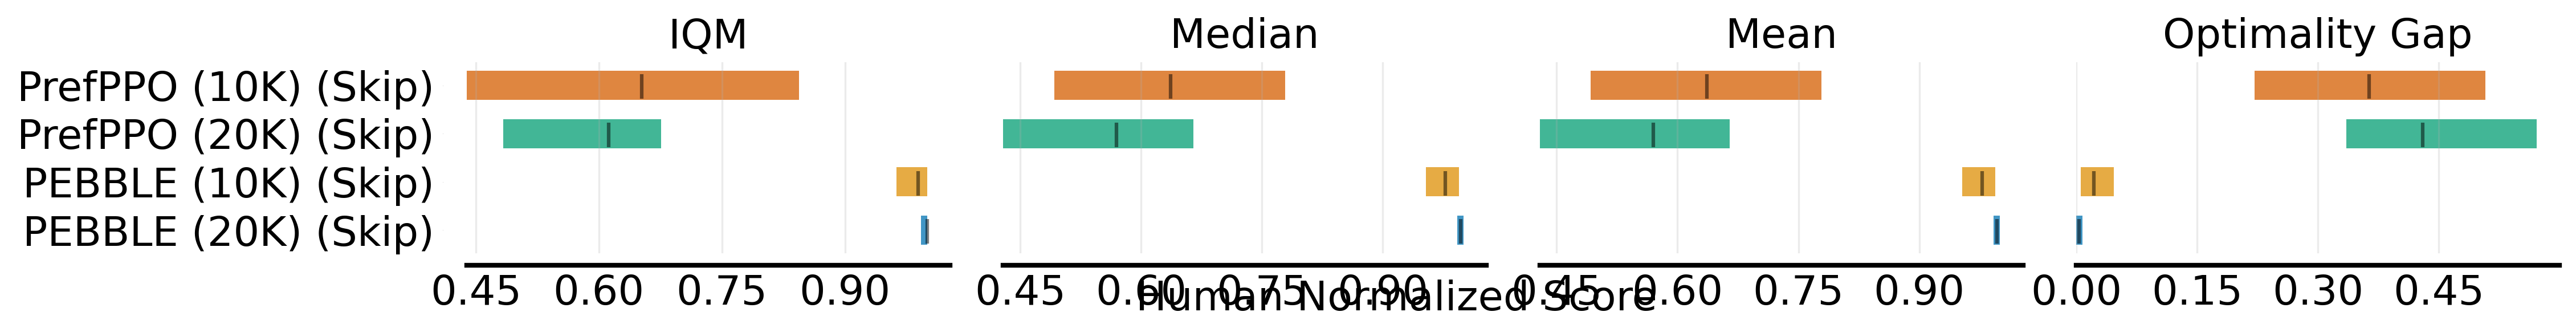

In [7]:
algorithms = ['PEBBLE (20K) (Skip)', 'PEBBLE (10K) (Skip)', 
              'PrefPPO (20K) (Skip)', 'PrefPPO (10K) (Skip)']
fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['IQM', 'Median',  'Mean', 'Optimality Gap'],
  algorithms=algorithms, xlabel='Human Normalized Score')

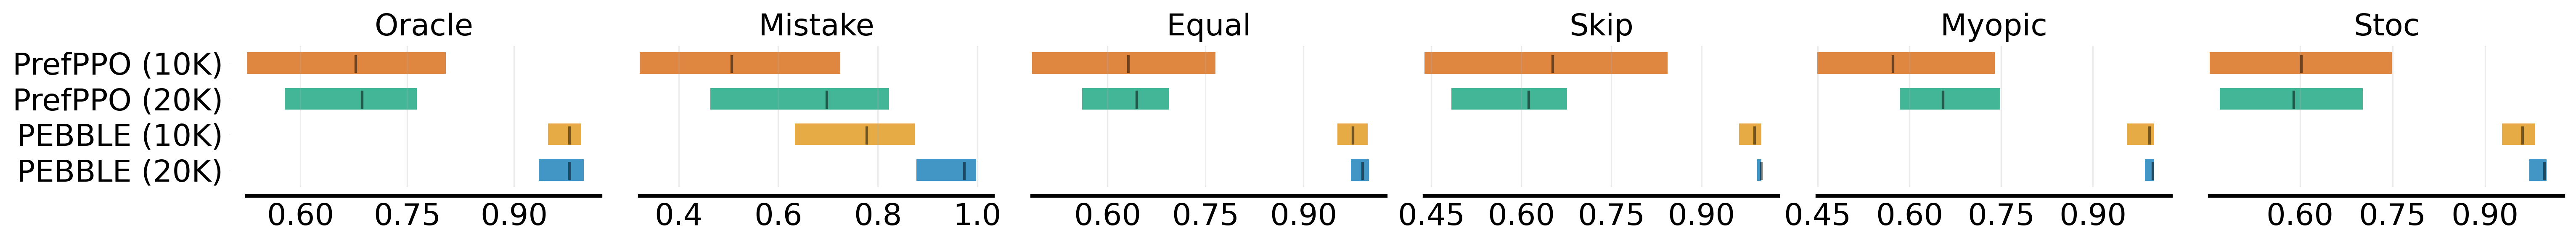

In [8]:
algorithms = ['PEBBLE (20K)', 'PEBBLE (10K)', 
              'PrefPPO (20K)', 'PrefPPO (10K)']
fig, axes = plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_idx=0,
  algorithms=algorithms, xlabel='Normalized Score')

plt.savefig('./figure/figure1_button_iqm.pdf',dpi=500, bbox_inches='tight')

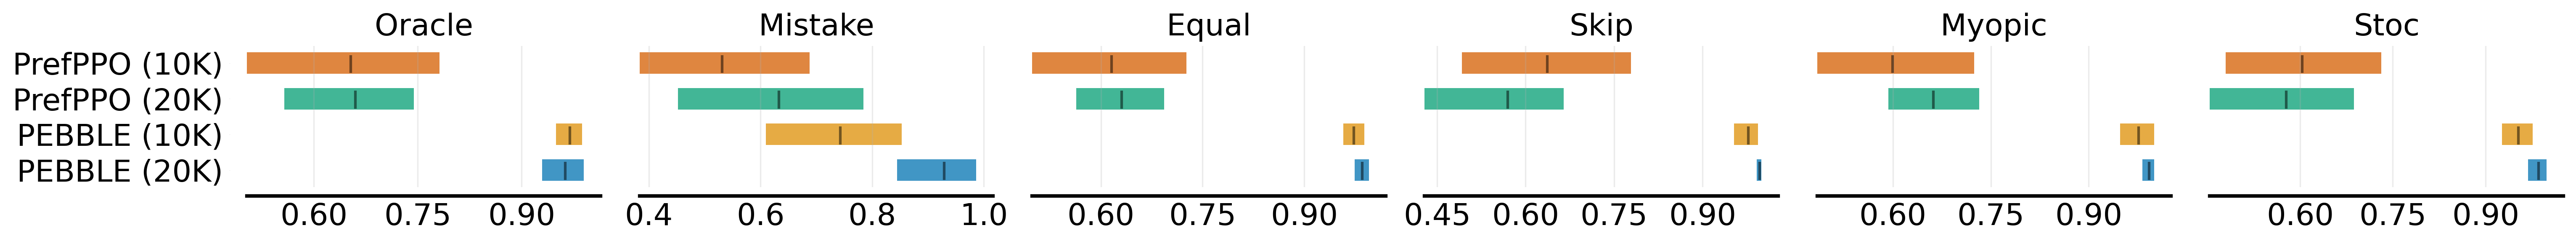

In [9]:
algorithms = ['PEBBLE (20K)', 'PEBBLE (10K)', 
              'PrefPPO (20K)', 'PrefPPO (10K)']
fig, axes = plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_idx=1,
  algorithms=algorithms, xlabel='Normalized Score')

plt.savefig('./figure/figure1_button_med.pdf',dpi=500, bbox_inches='tight')

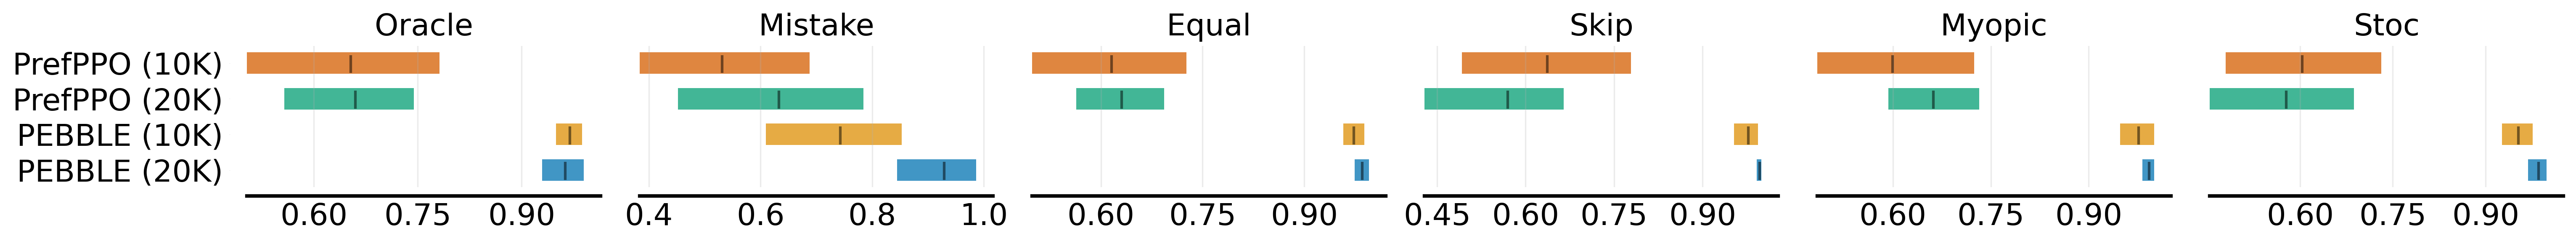

In [10]:
algorithms = ['PEBBLE (20K)', 'PEBBLE (10K)', 
              'PrefPPO (20K)', 'PrefPPO (10K)']
fig, axes = plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_idx=2,
  algorithms=algorithms, xlabel='Normalized Score')

plt.savefig('./figure/figure1_button_mean.pdf',dpi=500, bbox_inches='tight')

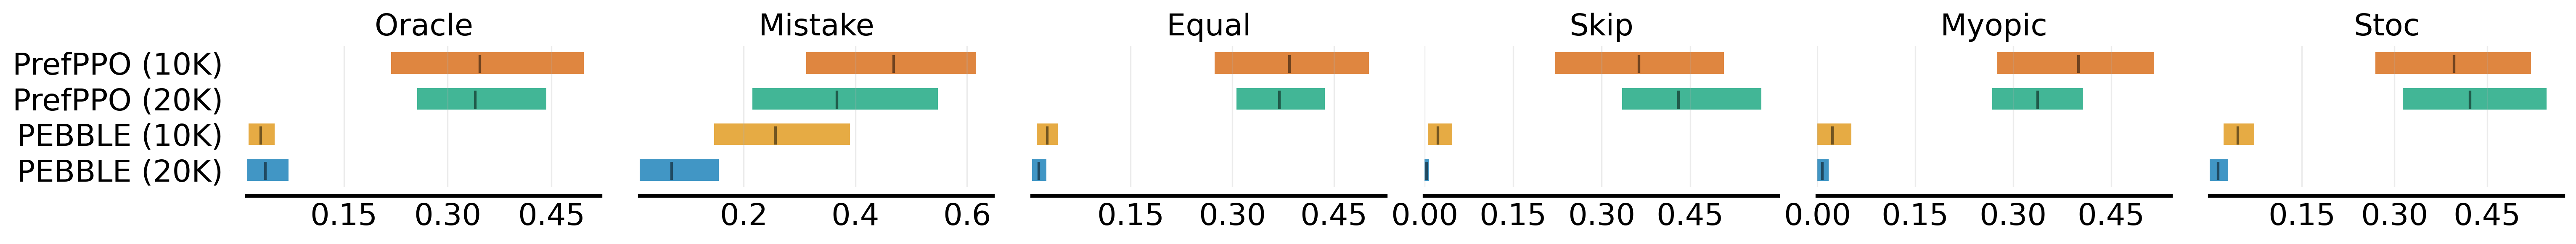

In [11]:
algorithms = ['PEBBLE (20K)', 'PEBBLE (10K)', 
              'PrefPPO (20K)', 'PrefPPO (10K)']
fig, axes = plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_idx=3,
  algorithms=algorithms, xlabel='Normalized Score')

plt.savefig('./figure/figure1_button_opgap.pdf',dpi=500, bbox_inches='tight')